### Loading images and labels


In [1]:
from scipy.misc import imread, imresize
#from keras.applications.imagenet_utils import preprocess_input
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Predicting on a batch of images

The predict_batch function is defined as follows:

    - open each image, and resize them to img_size
    - stack them as a batch tensor of shape (batch, img_size_x, img_size_y)
    - preprocess the batch and make a forward pass with the model



In [2]:
#def predict_batch(model, img_batch_path, img_size=None):
def predict_batch(folder, img_size=None):
    img_list = []
    label_list = []

    for filename in os.listdir(folder):
        
        if filename.endswith(".jpg"):
            img = imread(os.path.join(folder,filename))
            lb = filename.split('_')[1]
            lb = lb.lower()
        
        if img_size:
            img = imresize(img,img_size)

        img = img.astype('float32')
        
        # convert image to greyscale
        img = img.sum(axis=2) / 3.
        img /= np.std(img)
        
        img = img[:, :, np.newaxis]
        
        img_list.append(img)
        label_list.append(lb)
    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        raise ValueError(
            'when both img_size and crop_size are None, all images '
            'in image_paths must have the same shapes.')

    #batch = preprocess_input(img_batch)
    return img_batch, label_list 
            #model.predict(img_batch)

In [3]:
YOUR_FOLDER_NAME = "try"

output, labels = predict_batch(YOUR_FOLDER_NAME, (32, 100))
print("output shape", output.shape)
print ('label shape', len(labels))

output shape (523, 32, 100, 1)
label shape 523


In [232]:
labels

[]

In [233]:
X[1:2].shape

(1, 32, 100, 1)

In [ ]:
output[0][:,:,0].shape

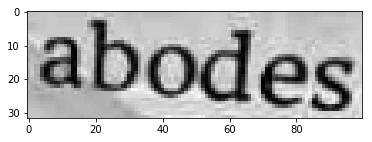

In [234]:
plt.imshow(X[1][:,:,0], cmap="gray")

### Conv-net model

The base CNN has five convolutional layers and two fully connected layers. 

In [208]:
import keras as ks
from keras.models import Model
from keras import models
from keras.layers import Flatten, Dropout, MaxPooling2D,Input
from keras.layers import Dense, InputLayer, Convolution2D
import logging
import numpy as np

import keras.backend as K
import tensorflow as tf

def squeeze_dim(x, axis=-1):
    # Removes a 1-dimension from the tensor at index "axis"
    return K.squeeze(x, axis=axis)


class CNN(object):
    """
    Usage for tf tensor output:
    o = CNN(x).tf_output()
    """

    def __init__(self, input_tensor):
        self._build_network(input_tensor)

    def _build_network(self, input_tensor):
        
        model_input = Input(shape=(32,100,1))#,tensor=input_tensor)

        conv_layers_size = [64,128,256,512,512]
        edges_size = [5,5,3,3,3]
        
        #convolutional layes
        x = model_input 
        for i,(layer_size, edge_size) in enumerate(zip(conv_layers_size,edges_size)):
            x = Convolution2D(
                layer_size, edge_size, edge_size, 
                activation='relu', subsample=(1, 1),border_mode='same')(x)
            if i <= 2 :
                x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
        #dense layers
        x = Flatten()(x)
        x = Dense(4096, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(4096)(x)
    
    
        N = 23
        outputs = []
        for i in range(N):
            outputs.append(Dense(37,activation='softmax')(x))
        
        self.model = Model(input=model_input,output=outputs)

    def tf_output(self):
        # if self.input_tensor is not None:
        return self.model.output

    def __call__(self, input_tensor):
        return self.model(input_tensor)
    
    def tf_summary(self):
        print(self.model.summary())

    def save(self, filename):
        self.model.save_weights(str(filename) + ".h5")
        print("Model saved to disk")


In [209]:
model_cnn = CNN(tf.Variable(output))

In [210]:
model_cnn.tf_summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_11 (InputLayer)            (None, 32, 100, 1)    0                                            
____________________________________________________________________________________________________
convolution2d_43 (Convolution2D) (None, 32, 100, 64)   1664        input_11[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_25 (MaxPooling2D)   (None, 16, 50, 64)    0           convolution2d_43[0][0]           
____________________________________________________________________________________________________
convolution2d_44 (Convolution2D) (None, 16, 50, 128)   204928      maxpooling2d_25[0][0]            
___________________________________________________________________________________________

In [199]:
model_cnn.save('model_null')

Model saved to disk


In [200]:
model = model_cnn.model

In [ ]:
from sklearn.model_selection import train_test_split 

In [11]:
X, y = predict_batch("try", (32, 100))

In [131]:
maxLen = 23
def word_to_labels(w):
    return list(w) + [" "]*(maxLen - len(w))

In [132]:
alphabet = "0123456789abcdefghijklmnopqrstuvwxyz "
V = len(list(alphabet))

In [133]:
def build_vocabulary(tokenized_sequences):
    rev_vocabulary = []
    unique_tokens = set()
    for tokens in tokenized_sequences:
        unique_tokens.update(tokens)
    rev_vocabulary += sorted(unique_tokens)
    vocabulary = {}
    for i, token in enumerate(rev_vocabulary):
        vocabulary[token] = i
    return vocabulary, rev_vocabulary

In [134]:
vocabulary, rev_vocabulary = build_vocabulary(list(alphabet))

In [138]:
def vectorize(w):
    letters = word_to_labels(w)
    vector = np.zeros((maxLen,V))
    for i, letter in enumerate(letters) :
        vector[i,vocabulary[letter]]=1
    return vector

In [140]:
vectorize('abcade').shape

(23, 37)

In [191]:
Y = []
labels = []
for word in y :
    #v = vectorize(word)
    Y.append(vectorize(word))
    
# Y.append(vectorize(word))
Y = np.array(Y)
Y = np.rollaxis(Y,1)
#Y = Y.T
Y_ = []
for row in Y:
    Y_.append(row)

In [169]:
w = vectorize(word)

In [192]:
Y.shape

(23, 523, 37)

In [206]:
len(Y_)

23

40

In [ ]:
#from sklearn.model_selection import train_test_split 
#X, y = predict_batch("try", (32, 100))
#X_train, X_test, y_train, y_test = train_test_split(
#...     X, y, test_size=0.4, random_state=0)

In [211]:
model = model_cnn.model
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.fit(X, Y_,
          batch_size=64, nb_epoch=15, 
          validation_split=0.1,shuffle=True, verbose=2)
#model.metrics
        

Train on 470 samples, validate on 53 samples
Epoch 1/15
81s - loss: 120.9547 - dense_181_loss: 13.4220 - dense_182_loss: 12.1586 - dense_183_loss: 13.3131 - dense_184_loss: 13.4676 - dense_185_loss: 13.2484 - dense_186_loss: 12.4473 - dense_187_loss: 13.7342 - dense_188_loss: 8.2421 - dense_189_loss: 6.0816 - dense_190_loss: 4.2640 - dense_191_loss: 2.5836 - dense_192_loss: 1.4176 - dense_193_loss: 1.0747 - dense_194_loss: 0.8689 - dense_195_loss: 0.6289 - dense_196_loss: 0.5260 - dense_197_loss: 0.5260 - dense_198_loss: 0.4917 - dense_199_loss: 0.4917 - dense_200_loss: 0.4917 - dense_201_loss: 0.4917 - dense_202_loss: 0.4917 - dense_203_loss: 0.4917 - dense_181_acc: 0.0596 - dense_182_acc: 0.1362 - dense_183_acc: 0.0660 - dense_184_acc: 0.0681 - dense_185_acc: 0.0723 - dense_186_acc: 0.1255 - dense_187_acc: 0.0489 - dense_188_acc: 0.3830 - dense_189_acc: 0.5191 - dense_190_acc: 0.6298 - dense_191_acc: 0.7362 - dense_192_acc: 0.8149 - dense_193_acc: 0.8298 - dense_194_acc: 0.8596 - den

In [245]:
y = model.predict(X[112:113])

In [246]:
s = ""
for i in range(23):
    s += rev_vocabulary[np.where(y[i][0]==1)[0][0]]
print(s)

baariel                
